#  <span style="color:orange">Regression Tutorial</span>

# 1.0  Tutorial Objective
Welcome to Regression Tutorial. This tutorial assumes that you are new to PyCaret and looking to get started with Regression using the `pycaret.regression` Module.

In this tutorial we will learn:

* **Setting up Environment:**  How to setup an experiment in PyCaret and get started with building regression models
* **Create Model:**  How to create a model, perform cross validation and evaluate regression metrics
* **Tune Model:**  How to automatically tune the hyperparameters of a regression model
* **Plot Model:**  How to analyze model performance using various plots
* **Finalize Model:** How to finalize the best model at the end of the experiment
* **Predict Model:**  How to make prediction on new / unseen data
* **Save / Load Model:**  How to save / load a model for future use



# 2.0 What is Regression?

Regression analysis is a set of statistical processes for estimating the relationships between a dependent variable (often called the 'outcome variable', or 'target') and one or more independent variables (often called 'features', 'predictors', or 'covariates'). The objective of regression in machine learning is **to predict continuous values** such as sales amount, quantity, temperature etc.

__[Learn More about Regression](https://hbr.org/2015/11/a-refresher-on-regression-analysis)__

# Import libraries

In [1]:
from pycaret.regression import *
from pycaret.datasets import get_data
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_regression

# 5.0 Getting the Data

In [ ]:
X, y = make_regression(n_samples=100, n_features=1, 
                             n_informative=1, noise=5, random_state=0)

In [ ]:
# X and y are 2-dimensional arrays so we need to use .flatten() to strech it out to 1D
sns.scatterplot(X.flatten(), y.flatten())

In [ ]:
# regplot() performs simple linear regression and draws line of best fit
sns.regplot(X.flatten(), y.flatten())

<div class='alert alert-warning'>
    <h4>Exercise 1a.</h4>
    Make new regression dataset that has 200 samples, noise 10 and 2 features. Use random_state 42. 
</div>

In [ ]:
# 1a)


In [68]:
# %load solutions/pyc_reg_1a.py

Overwriting solutions/pyc_reg_1a.py


<div class='alert alert-warning'>
    <h4>Exercise 1b.</h4>
    Make a Pandas DataFrame df with three columns X1, X2 and y using your regression data. Think how you can access the right indexes in 2D-arrays.
</div>


In [ ]:
# 1b)


In [35]:
# %load solutions/pyc_reg_1b.py

<div class='alert alert-warning'>
    <h4>Exercise 1c.</h4>
    Plot X1 and y using seaborn
</div>

In [ ]:
# 1c)


In [ ]:
# %load solutions/pyc_reg_1c.py

In order to demonstrate the `predict_model()` function on unseen data, a sample of 20 records has been withheld from the original dataset to be used for predictions. **This should not be confused with a train/test split** as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 20 records are not available at the time when the machine learning experiment was performed.

In [36]:
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (180, 3)
Unseen Data For Predictions: (20, 3)


# 6.0 Setting up Environment in PyCaret

The `setup()` function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. `setup()` must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline (we will see them in later tutorials).

When `setup()` is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after `setup()` is executed. If all of the data types are correctly identified `enter` can be pressed to continue or `quit` can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In later tutorials we will learn how to overwrite PyCaret's inferred data type using the `numeric_features` and `categorical_features` parameters in `setup()`.

In [37]:
exp_reg101 = setup(data = data, target = 'y', session_id=123) 

,Description,Value
0,Session id,123
1,Target,y
2,Target type,Regression
3,Data shape,"(180, 3)"
4,Train data shape,"(125, 3)"
5,Test data shape,"(55, 3)"
6,Numeric features,2
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


Once the setup has been succesfully executed it prints the information grid which contains several important pieces of information. Most of the information is related to the pre-processing pipeline which is constructed when `setup()` is executed. The majority of these features are out of scope for the purposes of this tutorial. However, a few important things to note at this stage include:

- **session_id :**  A pseudo-random number distributed as a seed in all functions for later reproducibility. If no `session_id` is passed, a random number is automatically generated that is distributed to all functions. In this experiment, the `session_id` is set as `123` for later reproducibility.<br/>
<br/>
- **Original Data :**  Displays the original shape of dataset. In this experiment (5400, 8) means 5400 samples and 8 features including the target column. <br/>
<br/>
- **Missing Values :**  When there are missing values in the original data, this will show as True. For this experiment there are no missing values in the dataset.<br/>
<br/>
- **Numeric Features :**  Number of features inferred as numeric. In this dataset, 1 out of 8 features are inferred as numeric. <br/>
<br/>
- **Categorical Features :**  Number of features inferred as categorical. In this dataset, 6 out of 8 features are inferred as categorical. <br/>
<br/>
- **Transformed Train Set :** Displays the shape of the transformed training set. Notice that the original shape of (5400, 8) is transformed into (3779, 28) for the transformed train set. The number of features has increased from 8 from 28 due to categorical encoding <br/>
<br/>
- **Transformed Test Set :** Displays the shape of transformed test/hold-out set. There are 1621 samples in test/hold-out set. This split is based on the default value of 70/30 that can be changed using `train_size` parameter in setup. <br/>

Notice how a few tasks that are imperative to perform modeling are automatically handled, such as missing value imputation (in this case there are no missing values in training data, but we still need imputers for unseen data), categorical encoding etc. Most of the parameters in `setup()` are optional and used for customizing the pre-processing pipeline. These parameters are out of scope for this tutorial but as you progress to the intermediate and expert levels, we will cover them in much greater detail.



# 7.0 Comparing All Models

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using k-fold cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE, R2, RMSLE and MAPE accross the folds (10 by default) along with training time.

In [38]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,8.2112,110.4576,10.2566,0.9009,0.5747,1.0061,0.0100
omp,Orthogonal Matching Pursuit,8.1967,108.5954,10.1859,0.9002,0.5731,1.0253,0.0090
huber,Huber Regressor,8.2580,109.4386,10.2365,0.8995,0.5729,0.9919,0.0090
ridge,Ridge Regression,8.2587,110.4829,10.2720,0.8994,0.5802,1.0010,0.0090
br,Bayesian Ridge,8.2557,110.2215,10.2635,0.8990,0.5799,1.0044,0.0110
lr,Linear Regression,8.2552,110.2047,10.2631,0.8989,0.5799,1.0049,0.0230
lar,Least Angle Regression,8.2552,110.2047,10.2631,0.8989,0.5799,1.0049,0.0090
par,Passive Aggressive Regressor,8.4735,119.9845,10.6988,0.8964,0.5492,1.0319,0.0100
ada,AdaBoost Regressor,9.8494,179.5226,12.5078,0.8667,0.7316,0.7929,0.0200
rf,Random Forest Regressor,10.2295,187.5371,12.7726,0.8651,0.7632,1.1847,0.0520


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

With simple line of code we have trained and evaluated 20 models using cross validation. The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using `R2` (highest to lowest) which can be changed by passing `sort` parameter. For example `compare_models(sort = 'RMSLE')` will sort the grid by RMSLE (lower to higher since lower is better). If you want to change the fold parameter from the default value of `10` to a different value then you can use the `fold` parameter. For example `compare_models(fold = 5)` will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time. By default, compare_models return the best performing model based on default sort order but can be used to return a list of top N models by using `n_select` parameter. </br>

Notice that how `exclude` parameter is used to block certain models (in this case `RANSAC`).

# 8.0 Create a Model

`create_model` is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold. 

For the remaining part of this tutorial, we will work with the below models as our candidate models. The selections are for illustration purposes only and do not necessarily mean they are the top performing or ideal for this type of data.

- AdaBoost Regressor ('ada')
- Light Gradient Boosting Machine ('lightgbm') 
- Decision Tree	 ('dt')

There are 25 regressors available in the model library of PyCaret. To see list of all regressors either check the docstring or use `models` function to see the library.

In [39]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


### 8.1 Linear regression

In [40]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.7173,126.3784,11.2418,0.8857,0.8634,0.4407
1,10.4963,169.9986,13.0383,0.8594,0.5853,0.7898
2,11.4252,178.5549,13.3624,0.9596,0.9165,0.3680
3,8.2590,98.9281,9.9463,0.9413,0.2854,0.2647
4,8.6188,102.2489,10.1118,0.8631,0.4422,0.7780
5,8.3311,134.2543,11.5868,0.7347,0.3479,0.7616
6,6.0279,52.8947,7.2729,0.9666,0.4484,0.3795
7,5.2341,42.3618,6.5086,0.9181,0.5054,0.6592
8,8.0225,129.4050,11.3756,0.9430,0.6694,0.2728


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### 8.2 Light Gradient Boosting Machine 

In [41]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11.4100,191.3248,13.8320,0.8270,0.9594,1.1377
1,12.0832,301.6709,17.3687,0.7505,0.8084,1.2465
2,28.7103,1372.4180,37.0462,0.6898,1.1455,0.6469
3,11.1181,229.4010,15.1460,0.8639,0.3696,0.3523
4,9.1073,142.5940,11.9413,0.8091,0.5337,0.9595
5,12.8580,319.1248,17.8641,0.3695,0.5005,1.0539
6,9.2501,188.3162,13.7228,0.8812,0.7581,0.5239
7,5.0901,40.2190,6.3418,0.9222,0.6311,0.8523
8,11.8318,268.4895,16.3856,0.8817,0.3058,0.3655


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### 8.3 Decision Tree

In [42]:
dt = create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15.1028,338.9367,18.4102,0.6936,0.7224,0.8667
1,16.7937,365.1178,19.1081,0.6980,0.8306,2.1782
2,19.2076,590.5339,24.3009,0.8665,0.5618,0.5642
3,14.2352,249.6458,15.8002,0.8519,0.4724,0.5271
4,9.7142,133.7534,11.5652,0.8209,0.6904,1.1133
5,11.6585,223.9955,14.9665,0.5574,0.6064,1.0204
6,12.0898,199.9824,14.1415,0.8738,0.6011,0.8201
7,4.6961,39.9833,6.3232,0.9227,0.4577,0.6839
8,12.2951,238.4180,15.4408,0.8949,0.7834,0.3809


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Notice that the Mean score of all models matches with the score printed in `compare_models()`. This is because the metrics printed in the `compare_models()` score grid are the average scores across all cross-validation (CV) folds. Similar to `compare_models()`, if you want to change the fold parameter from the default value of 10 to a different value then you can use the `fold` parameter. For Example: `create_model('dt', fold = 5)` to create Decision Tree using 5 fold cross validation.

# 9.0 Tune a Model

When a model is created using the `create_model` function it uses the default hyperparameters to train the model. In order to tune hyperparameters, the `tune_model` function is used. This function automatically tunes the hyperparameters of a model using `Random Grid Search` on a pre-defined search space. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold. To use the custom search grid, you can pass `custom_grid` parameter in the `tune_model` function (see 9.2 LightGBM tuning below).

### 9.1 Linear regression

In [43]:
tuned_lr = tune_model(lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.6662,124.0769,11.1390,0.8878,0.8244,0.4077
1,10.5137,170.3707,13.0526,0.8591,0.5845,0.7989
2,11.3822,176.4938,13.2851,0.9601,0.8466,0.3715
3,8.2455,98.8516,9.9424,0.9414,0.2807,0.2628
4,8.3565,96.6071,9.8289,0.8707,0.4521,0.7622
5,8.4007,132.6341,11.5167,0.7379,0.3724,0.7603
6,5.7736,51.2283,7.1574,0.9677,0.4611,0.3622
7,5.1712,41.9148,6.4742,0.9190,0.4789,0.6294
8,8.0596,129.7930,11.3927,0.9428,0.6256,0.2738


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### 9.2 Light Gradient Boosting Machine

In [45]:
import numpy as np

# using custom parameters for tuning
# you don't need to understand the parameters, this is just to show how parameters can be tweaked
lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': np.arange(0.1,1,0.1)
                        }

tuned_lightgbm = tune_model(lightgbm, custom_grid = lgbm_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11.4100,191.3248,13.8320,0.8270,0.9594,1.1377
1,12.0832,301.6709,17.3687,0.7505,0.8084,1.2465
2,28.7103,1372.4180,37.0462,0.6898,1.1455,0.6469
3,11.1181,229.4010,15.1460,0.8639,0.3696,0.3523
4,9.1073,142.5940,11.9413,0.8091,0.5337,0.9595
5,12.8580,319.1248,17.8641,0.3695,0.5005,1.0539
6,9.2501,188.3162,13.7228,0.8812,0.7581,0.5239
7,5.0901,40.2190,6.3418,0.9222,0.6311,0.8523
8,11.8318,268.4895,16.3856,0.8817,0.3058,0.3655


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### 9.3 Decision Tree

In [44]:
tuned_dt = tune_model(dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.3970,265.2372,16.2861,0.7602,1.0708,1.5947
1,13.6414,306.2347,17.4996,0.7467,0.8857,1.5361
2,22.1661,808.8148,28.4397,0.8172,0.5567,0.6454
3,9.7643,141.0596,11.8769,0.9163,0.3400,0.3336
4,7.7233,82.1679,9.0647,0.8900,0.6231,0.7742
5,8.6423,109.4914,10.4638,0.7837,0.5123,0.6690
6,12.6248,205.7049,14.3424,0.8702,0.6590,0.8453
7,5.4546,51.9164,7.2053,0.8996,0.5677,0.7153
8,9.4903,148.6323,12.1915,0.9345,0.4761,0.3036


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


By default, `tune_model` optimizes `R2` but this can be changed using optimize parameter. For example: tune_model(dt, optimize = 'MAE') will search for the hyperparameters of a Decision Tree Regressor that results in the lowest `MAE` instead of highest `R2`. For the purposes of this example, we have used the default metric `R2` for the sake of simplicity only. The methodology behind selecting the right metric to evaluate a regressor is beyond the scope of this tutorial but if you would like to learn more about it, you can __[click here](https://www.dataquest.io/blog/understanding-regression-error-metrics/)__ to develop an understanding on regression error metrics.

Metrics alone are not the only criteria you should consider when finalizing the best model for production. Other factors to consider include training time, standard deviation of k-folds etc.

# 10.0 Plot a Model

Before model finalization, the `plot_model()` function can be used to analyze the performance across different aspects such as Residuals Plot, Prediction Error, Feature Importance etc. This function takes a trained model object and returns a plot based on the test / hold-out set. 

There are over 10 plots available, please see the `plot_model()` docstring for the list of available plots.

### 10.1 Residual Plot

A residual value tells how much regression line vertically misses a data point. Regression lines are the best fit of a set of data. You can think of the lines as averages; a few data points will fit the line and others will miss. A residual plot has the Residual Values on the vertical axis; the horizontal axis displays the independent variable.

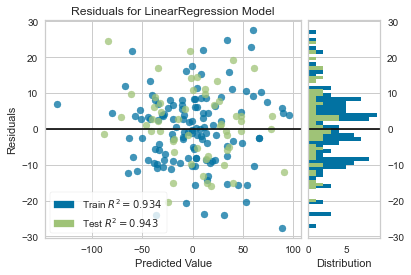

In [46]:
plot_model(tuned_lr) #without additional parameters plot_model gives residual plot

### 10.2 Prediction Error Plot

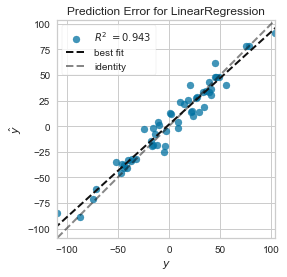

In [47]:
plot_model(tuned_lr, plot = 'error')

### 10.3 Feature Importance Plot

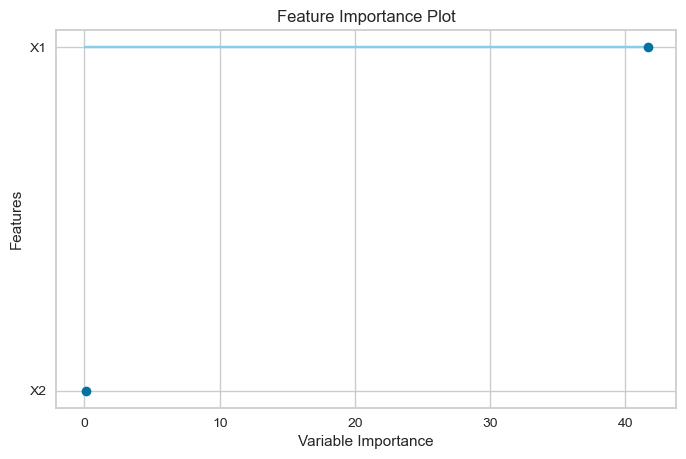

In [48]:
plot_model(tuned_lr, plot='feature')

*Another* way to analyze the performance of models is to use the `evaluate_model()` function which displays a user interface for all of the available plots for a given model. It internally uses the `plot_model()` function.

In [49]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# 11.0 Predict on Test / Hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. If you look at the information grid in Section 6 above, you will see that 30% of the data has been separated out as a test/hold-out sample. All of the evaluation metrics we have seen above are cross-validated results based on training set (70%) only. Now, using our final trained model stored in the `tuned_lr` variable we will predict the hold-out sample and evaluate the metrics to see if they are materially different than the cross-validation (CV) results.

In [50]:
predict_model(tuned_lr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,7.9277,102.0851,10.1037,0.9433,0.7050,0.6872


The R2 on the test/hold-out set is **`0.9433`** compared to **`0.9004`** achieved on `tuned_lr` (see 9.1). If there is a large variation between the test/hold-out and CV results, then this would normally indicate over-fitting but could also be due to several other factors and would require further investigation. In this case, we will move forward with finalizing the model and predicting on unseen data (the 10% that we had separated in the beginning and never exposed to PyCaret).

(TIP : It's always good to look at the standard deviation of CV results when using `create_model`.)

# 12.0 Finalize Model for Deployment

Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with `setup()`, followed by comparing all models using `compare_models()` and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. This workflow will eventually lead you to the best model for use in making predictions on new and unseen data. The `finalize_model()` function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [51]:
final_lr = finalize_model(tuned_lr)

In [52]:
print(final_lr)

LinearRegression(fit_intercept=False, n_jobs=-1, normalize=False)


**Caution:** One final word of caution. Once the model is finalized using `finalize_model()`, the entire dataset including the test/hold-out set is used for training. As such, if the model is used for predictions on the hold-out set after `finalize_model()` is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling. In order to demonstrate this point only, we will use `final_lightgbm` under `predict_model()` to compare the information grid with the one above in section 11. 

In [53]:
predict_model(final_lr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,7.8708,100.5799,10.0290,0.9442,0.7118,0.6943


Notice how the R2 in the `final_lr` has increased to **`0.9442`**, even though the model is same. This is because the `final_lr` variable is trained on the complete dataset including the test/hold-out set.

# 13.0 Predict on Unseen Data

The `predict_model()` function is also used to predict on the unseen dataset. The only difference from section 11 above is that this time we will pass the `data_unseen` parameter. `data_unseen` is the variable created at the beginning of the tutorial and contains 10% of the original dataset which was never exposed to PyCaret. (see section 5 for explanation)

In [54]:
unseen_predictions = predict_model(final_lr, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,6.5471,78.1551,8.8405,0.9639,0.4297,0.2762


,X1,X2,y,Label
0,-1.191303,0.656554,-39.731361,-50.319649
1,-1.150994,0.375698,-50.784103,-48.594482
2,0.915402,0.328751,42.003857,38.593285
3,0.515048,3.852731,35.322502,21.395145
4,-1.724918,-0.562288,-87.544189,-72.727386


The `Label` column is added onto the `data_unseen` set. Label is the predicted value using the `final_lightgbm` model. If you want predictions to be rounded, you can use `round` parameter inside `predict_model()`. You can also check the metrics on this since you have actual target column `Price` available. To do that we will use pycaret.utils module. See example below:

In [55]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.y, unseen_predictions.Label, 'R2')

0.9639

# 14.0 Saving the Model

We have now finished the experiment by finalizing the `tuned_lr` model which is now stored in `final_lr` variable. We have also used the model stored in `final_lr` to predict `data_unseen`. This brings us to the end of our experiment, but one question is still to be asked: What happens when you have more new data to predict? Do you have to go through the entire experiment again? The answer is no, PyCaret's inbuilt function `save_model()` allows you to save the model along with entire transformation pipeline for later use.

You can use this function to save any model (including scikit-learn models). 

In [67]:
save_model(final_lr,'linearRegression_model_14092022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\Computer\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['X1', 'X2'], transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[], transformer=SimpleImputer(fill_value='constant', strategy='constant'))),
                 ['trained_model',
                  LinearRegression(fit_intercept=False, n_jobs=-1,
                                   normalize=False)]]),
 'linearRegression_model_14092022.pkl')

(TIP : It's always good to use date in the filename when saving models, it's good for version control.)

# 15.0 Loading the Saved Model

To load a saved model at a future date in the same or an alternative environment, we would use PyCaret's `load_model()` function and then easily apply the saved model on new unseen data for prediction.

In [ ]:
saved_final_lr = load_model('linearRegression_model_14092022')

Once the model is loaded in the environment, you can simply use it to predict on any new data using the same `predict_model()` function. Below we have applied the loaded model to predict the same `data_unseen` that we used in section 13 above.

In [ ]:
new_prediction = predict_model(saved_final_lr, data=data_unseen)

In [ ]:
new_prediction.head()

Notice that the results of `unseen_predictions` and `new_prediction` are identical.

In [ ]:
from pycaret.utils import check_metric
check_metric(new_prediction.y, new_prediction.Label, 'R2')